In [1]:
import astroplan
from astropy.coordinates import ICRS, SkyCoord, AltAz
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model
# from gurobipy import GRB,Env, Model_
# env = Env(params={"WLSACCESSID": "c33d3a26-e111-4b61-b670-f9b9be9b4395",
#                   "WLSSECRET": "001698e8-35d4-450f-8fbe-b63f304b8f2b",
#                   "LICENSEID": 2533050})
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

/u/ywagh/.local/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])
print(filelist)

['001.gz', '002.gz', '003.gz', '004.gz', '005.gz', '006.gz', '007.gz', '008.gz', '009.gz', '010.gz', '011.gz', '012.gz', '013.gz', '014.gz', '015.gz', '016.gz', '017.gz', '018.gz', '019.gz', '020.gz', '021.gz', '022.gz', '023.gz', '024.gz', '025.gz', '026.gz', '027.gz', '028.gz', '029.gz', '030.gz', '031.gz', '032.gz', '033.gz', '034.gz', '035.gz', '036.gz', '037.gz', '038.gz', '039.gz', '040.gz', '041.gz', '042.gz', '043.gz', '044.gz', '045.gz', '046.gz', '047.gz', '048.gz', '049.gz', '050.gz', '051.gz', '052.gz', '053.gz', '054.gz', '055.gz', '056.gz', '057.gz', '058.gz', '059.gz', '060.gz', '061.gz', '062.gz', '063.gz', '064.gz', '065.gz', '066.gz', '067.gz', '068.gz', '069.gz', '070.gz', '071.gz', '072.gz', '073.gz', '074.gz', '075.gz', '076.gz', '077.gz', '078.gz', '079.gz', '080.gz', '081.gz', '082.gz', '083.gz', '084.gz', '085.gz', '086.gz', '087.gz', '088.gz', '089.gz', '090.gz', '091.gz', '092.gz', '093.gz', '094.gz', '095.gz', '096.gz', '097.gz', '098.gz', '099.gz', '100.gz',

In [3]:
slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]

def get_footprint(center):
    return SkyCoord(
        ew_vertices, ns_vertices,
        frame=center[..., np.newaxis, np.newaxis].skyoffset_frame()
    ).icrs

url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881] 
skymap, metadata = read_sky_map(os.path.join(directory_path, filelist[0]))
# print("SkyMap loaded")
plot_filename = os.path.basename(filelist[0])

event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
end_time = observer.sun_rise_time(
    start_time, horizon=night_horizon, which='next')

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.
target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
# sequence of 1800 seconds.
exposure_time = 300 * u.second
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)
print("problem setup completed")


event time: 2019-11-20 16:23:34.439


/u/ywagh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  0%|          | 0/560 [00:00<?, ?it/s]

problem setup completed


In [4]:
m = Model('real_telescope')

# field_vars = [m.addVar(vtype=GRB.BINARY) for _ in range(len(footprints))]
# pixel_vars = [m.addVar(vtype=GRB.BINARY) for _ in range(hpx.npix)]

field_vars = m.binary_var_list(len(footprints), name='field')
pixel_vars = m.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
     m.add_constraint(m.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m.add_constraint(m.sum(field_vars) <= 30)
m.maximize(m.dot(pixel_vars, prob))

# m.optimize()

solution = m.solve(log_output=True)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.02 sec. (24.20 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 784941 rows and 586439 columns.
Aggregator did 303 substitutions.
Reduced MIP has 1189 rows, 1487 columns, and 4349 nonzeros.
Reduced MIP has 1487 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.74 sec. (748.97 ticks)
Probing time = 0.00 sec. (0.30 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 3 rows and 0 columns.
Reduced MIP has 1186 rows, 1484 columns, and 4340 nonzeros.
Reduced MIP has 1484 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.93 ticks)
Probing time = 0.00 sec. (0.30 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.00 sec. (2.48 ticks)

        Nod

In [5]:
if solution:
    print("Optimization completed")
    total_prob_covered = solution.objective_value
    selected_fields = observable_fields[[solution.get_value(v) == 1 for v in field_vars]]
else:
    print("No solution found")

Optimization completed


In [6]:
separation_matrix = selected_fields['coord'][:,np.newaxis].separation(selected_fields['coord'][np.newaxis,:])


def slew_time(separation):
   return np.where(
       separation <= (slew_speed**2 / slew_accel), 
       np.sqrt(2 * separation / slew_accel), 
       (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed
       )

slew_times = slew_time(separation_matrix).to_value(u.day)
slew_times = 5 * slew_times

In [7]:
np.max(slew_times)

0.004273114141297981

In [8]:
delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()

In [9]:
m = Model('real_telescope')  #for docplex
m.parameters.timelimit = 60
t = [m.continuous_var(
        lb=(row['start_time'] - start_time).to_value(u.day),
        ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
        name=f't_{i}'
     ) for i, row in enumerate(selected_fields)]
x = [m.binary_var(name=f'x_{i}') for i in range(len(t))]
s = [[m.binary_var(name=f's_{i}_{j}') for j in range(i)] for i in range(len(t))]

for i in range(len(t)):
    for j in range(i):
        # Constraints for time sequencing between fields i and j
        m.add_constraint(t[i] + delta * x[i] - t[j] <= M * (1 - s[i][j]), ctname=f'constr1_{i}_{j}')
        m.add_constraint(t[j] + delta * x[j] - t[i] <= M * s[i][j], ctname=f'constr2_{i}_{j}')
m.maximize(m.sum(x))
solution = m.solve(log_output=True)


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
Tried aggregator 1 time.
MIP Presolve eliminated 432 rows and 216 columns.
MIP Presolve modified 657 coefficients.
Reduced MIP has 438 rows, 279 columns, and 1752 nonzeros.
Reduced MIP has 249 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.09 ticks)
Found incumbent of value 0.000000 after 0.01 sec. (1.47 ticks)
Probing time = 0.00 sec. (0.27 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 132 rows and 90 columns.
MIP Presolve modified 27 coefficients.
Reduced MIP has 306 rows, 189 columns, and 1224 nonzeros.
Reduced MIP has 171 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.61 ticks)
Probing time = 0.00 sec. (0.21 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 306 rows, 189 columns, and 1224 nonzeros.
Reduced MIP has 171 binaries, 0 general

Optimization completed


/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 30 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 30 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Text(0, 0.5, 'Field ID')

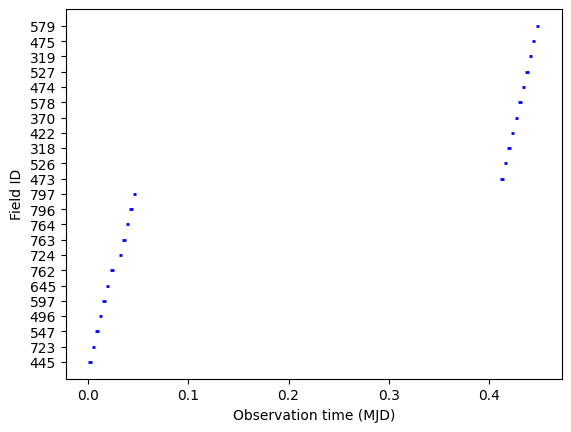

In [10]:

if solution:
    print("Optimization completed")
    scheduled_start_times = [solution.get_value(var) for var in t]
    scheduled_fields = QTable(selected_fields)
    scheduled_fields['scheduled_start_time'] = Time(scheduled_start_times, format='mjd')
    scheduled_fields['scheduled_start_time'].format = 'iso'
    scheduled_fields['scheduled_end_time'] = scheduled_fields['scheduled_start_time'] + exposure_time
    scheduled_fields = scheduled_fields[np.asarray([solution.get_value(var) for var in x], dtype=bool)]
    scheduled_fields.sort('scheduled_start_time')
else:
    print("No solution found")
fig, ax = plt.subplots()
ax.hlines(
    np.arange(len(scheduled_fields)), 
    scheduled_fields['scheduled_start_time'].mjd, 
    scheduled_fields['scheduled_end_time'].mjd,    
    colors='blue', linewidth=2) 
ax.set_yticks(np.arange(len(scheduled_fields)))
ax.set_yticklabels(scheduled_fields['field_id'].astype(str))
ax.set_xlabel('Observation time (MJD)')
ax.set_ylabel('Field ID')

In [11]:
print(solution)

solution for: real_telescope
objective: 23
status: FEASIBLE_SOLUTION(1)
t_0=0.447
t_1=0.418
t_2=0.440
t_3=0.426
t_4=0.447
t_5=0.422
t_6=0.443
t_8=0.411
t_9=0.433
t_10=0.443
t_11=0.010
t_12=0.415
t_13=0.436
t_14=0.007
t_15=0.429
t_16=0.447
t_17=0.014
t_18=0.436
t_19=0.447
t_20=0.017
t_21=0.443
t_22=0.447
t_23=0.003
t_24=0.031
t_25=0.022
t_26=0.034
t_27=0.038
t_28=0.041
t_29=0.044
x_1=1
x_2=1
x_3=1
x_5=1
x_7=1
x_8=1
x_9=1
x_10=1
x_11=1
x_12=1
x_13=1
x_14=1
x_15=1
x_16=1
x_17=1
x_20=1
x_23=1
x_24=1
x_25=1
x_26=1
x_27=1
x_28=1
x_29=1
s_1_0=1
s_2_0=1
s_3_0=1
s_3_2=1
s_4_0=1
s_5_0=1
s_5_2=1
s_5_3=1
s_5_4=1
s_6_0=1
s_6_4=1
s_7_0=1
s_7_1=1
s_7_2=1
s_7_3=1
s_7_4=1
s_7_5=1
s_7_6=1
s_8_0=1
s_8_1=1
s_8_2=1
s_8_3=1
s_8_4=1
s_8_5=1
s_8_6=1
s_9_0=1
s_9_2=1
s_9_4=1
s_9_6=1
s_10_0=1
s_10_4=1
s_11_0=1
s_11_1=1
s_11_2=1
s_11_3=1
s_11_4=1
s_11_5=1
s_11_6=1
s_11_8=1
s_11_9=1
s_11_10=1
s_12_0=1
s_12_1=1
s_12_2=1
s_12_3=1
s_12_4=1
s_12_5=1
s_12_6=1
s_12_9=1
s_12_10=1
s_13_0=1
s_13_2=1
s_13_4=1
s_13_6=1
s_13_